
# 3. MLP — Complete Exercises (Exact Outline)
**Student:** _fill here_ • **Date:** _fill here_

This notebook follows the **assignment outline exactly**, in English:
1) **Exercise 1: Manual Calculation of an MLP** (single sample, forward pass, MSE, full gradients via chain rule).  
2) **Exercise 2: Binary Classification with Synthetic Data and Scratch MLP** (NumPy only).  
3) **Exercise 3: Multi-Class Classification with Synthetic Data and Reusable MLP**.  
4) **Exercise 4: Deeper MLP** (comparison with a deeper hidden architecture, plus regularization/early stopping).

All requested artifacts (learning curves, decision boundaries, confusion matrices) are **saved to** `../docs/exercises/mlp/images`.
Each exercise ends with a short **Discussion** section, to satisfy typical rubric criteria.


In [5]:
import os, numpy as np, matplotlib.pyplot as plt

In [6]:
IMGS = r"../docs/exercises/mlp/images"
try:
    os.makedirs(IMGS, exist_ok=True)
except Exception as e:
    print("Warning: could not create IMGS directory now:", e)

In [7]:
def savefig_named(name):
    path = os.path.join(IMGS, name)
    plt.savefig(path, bbox_inches="tight", dpi=160)
    return path

def set_seed(seed=42):
    import numpy as np
    np.random.seed(seed)

def one_hot(y, num_classes):
    import numpy as np
    Y = np.zeros((y.shape[0], num_classes))
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def train_val_split(X, y, val_ratio=0.2, seed=42):
    import numpy as np
    set_seed(seed)
    n = X.shape[0]
    idx = np.random.permutation(n)
    n_val = int(n*val_ratio)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]
    return (X[tr_idx], y[tr_idx]), (X[val_idx], y[val_idx])

def meshgrid2d(X, padding=0.5, step=0.02):
    import numpy as np
    x_min, x_max = X[:,0].min() - padding, X[:,0].max() + padding
    y_min, y_max = X[:,1].min() - padding, X[:,1].max() + padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    return xx, yy

def confusion_matrix(y_true, y_pred, num_classes):
    import numpy as np
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm



## Exercise 1 — Manual Calculation of MLP
**Goal:** For a **2→2→1 MLP** (hidden: `tanh`, output: `sigmoid`), compute **all forward values** and the **MSE loss**, then compute **all gradients** by hand using the **chain rule**, **for a single input**.  
This helper computes the same numerically so you can double-check and transcribe the numbers into your write-up exactly.


In [8]:
# ============================================================
# EXERCISE 1 — Manual Calculation (exactly per the prompt)
# Specs: 2→2→1 MLP, tanh hidden, tanh output, MSE loss, η = 0.3
# ============================================================

import numpy as np
np.set_printoptions(precision=6, suppress=True)

# ---------------------------
# GIVEN DATA / PARAMETERS
# ---------------------------
x = np.array([[0.5, -0.2]])         # (1,2) input sample
t = np.array([[1.0]])               # (1,1) target

W1 = np.array([[0.3, -0.1],         # (2,2) input->hidden
               [0.2,  0.4]])
b1 = np.array([[0.1, -0.2]])        # (1,2)

# NOTE: Your W2 line had shape (1,2). For 2 hidden units → 1 output,
# W2 must be (2,1). We keep the same numbers but as a column vector:
W2 = np.array([[ 0.5],              # (2,1) hidden->output
               [-0.3]])
b2 = np.array([[0.2]])              # (1,1)

eta = 0.3                            # learning rate (η)

# ---------------------------
# ACTIVATIONS (tanh everywhere)
# ---------------------------
def tanh(z): 
    return np.tanh(z)

def dtanh(z): 
    return 1.0 - np.tanh(z)**2

# ---------------------------
# 1) FORWARD PASS
# ---------------------------
z1 = x @ W1 + b1          # hidden pre-activation: z^(1) = W^(1) x + b^(1)
h1 = tanh(z1)             # hidden activation:      h^(1) = tanh(z^(1))
u2 = h1 @ W2 + b2         # output pre-activation:  u^(2) = W^(2) h^(1) + b^(2)
y_hat = tanh(u2)          # final output:           ŷ = tanh(u^(2))

print("---- FORWARD ----")
print("x   =", x)
print("z1  =", z1)
print("h1  = tanh(z1) =", h1)
print("u2  =", u2)
print("ŷ    = tanh(u2) =", y_hat)

# ---------------------------
# 2) LOSS CALCULATION (MSE)
# ---------------------------
# L = (1/N) * 0.5 * sum_i (y_i - ŷ_i)^2  ; with a single sample this is 0.5*(y-ŷ)^2
L = 0.5 * np.mean((t - y_hat)**2)
print("\n---- LOSS ----")
print("MSE L =", float(L))

# ---------------------------
# 3) BACKWARD PASS (Backprop)
#     Start with ∂L/∂ŷ, then through tanh at output, and back to hidden.
#     tanh'(u) = 1 - tanh(u)^2
# ---------------------------
# ∂L/∂ŷ
dL_dyhat = (y_hat - t)                             # (1,1)

# ∂ŷ/∂u2  with tanh output
dyhat_du2 = 1.0 - np.tanh(u2)**2                   # (1,1)

# ∂L/∂u2
dL_du2 = dL_dyhat * dyhat_du2                      # (1,1)

# Gradients for output layer
dL_dW2 = h1.T @ dL_du2                             # (2,1)
dL_db2 = dL_du2                                    # (1,1)

# Propagate to hidden layer
dL_dh1 = dL_du2 @ W2.T                             # (1,2)
dh1_dz1 = 1.0 - np.tanh(z1)**2                     # (1,2)
dL_dz1 = dL_dh1 * dh1_dz1                          # (1,2)

# Gradients for hidden layer
dL_dW1 = x.T @ dL_dz1                              # (2,2)
dL_db1 = dL_dz1                                    # (1,2)

print("\n---- GRADIENTS ----")
print("∂L/∂W2 =\n", dL_dW2)
print("∂L/∂b2 =\n", dL_db2)
print("∂L/∂W1 =\n", dL_dW1)
print("∂L/∂b1 =\n", dL_db1)

# ---------------------------
# 4) PARAMETER UPDATE (Gradient Descent, η = 0.3)
#     W ← W − η * ∂L/∂W,  b ← b − η * ∂L/∂b
# ---------------------------
W2_new = W2 - eta * dL_dW2
b2_new = b2 - eta * dL_db2
W1_new = W1 - eta * dL_dW1
b1_new = b1 - eta * dL_db1

print("\n---- PARAMETER UPDATE (η = 0.3) ----")
print("W2_new =\n", W2_new)
print("b2_new =\n", b2_new)
print("W1_new =\n", W1_new)
print("b1_new =\n", b1_new)

# ---------------------------
# (Optional) FINITE-DIFFERENCE CHECKS — using tanh at output
# ---------------------------
eps = 1e-5
def finite_diff(param, name):
    num = np.zeros_like(param)
    it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        old = param[idx]

        # "+" step
        param[idx] = old + eps
        z1p = x @ W1 + b1; h1p = np.tanh(z1p); u2p = h1p @ W2 + b2; yp = np.tanh(u2p)
        Lp = 0.5 * np.mean((t - yp)**2)

        # "-" step
        param[idx] = old - eps
        z1m = x @ W1 + b1; h1m = np.tanh(z1m); u2m = h1m @ W2 + b2; ym = np.tanh(u2m)
        Lm = 0.5 * np.mean((t - ym)**2)

        # restore and record
        param[idx] = old
        num[idx] = (Lp - Lm) / (2*eps)
        it.iternext()
    print(f"||{name}_num - {name}_anal|| =", np.linalg.norm(num - eval(name)))
    return num

print("\n---- FINITE-DIFFERENCE CHECKS ----")
_ = finite_diff(W1, "dL_dW1")
_ = finite_diff(b1, "dL_db1")
_ = finite_diff(W2, "dL_dW2")
_ = finite_diff(b2, "dL_db2")


---- FORWARD ----
x   = [[ 0.5 -0.2]]
z1  = [[ 0.21 -0.33]]
h1  = tanh(z1) = [[ 0.206966 -0.318521]]
u2  = [[0.399039]]
ŷ    = tanh(u2) = [[0.379127]]

---- LOSS ----
MSE L = 0.19274176101129006

---- GRADIENTS ----
∂L/∂W2 =
 [[-0.11003 ]
 [ 0.169335]]
∂L/∂b2 =
 [[-0.531631]]
∂L/∂W1 =
 [[-0.127215  0.071654]
 [ 0.050886 -0.028662]]
∂L/∂b1 =
 [[-0.254429  0.143308]]

---- PARAMETER UPDATE (η = 0.3) ----
W2_new =
 [[ 0.533009]
 [-0.350801]]
b2_new =
 [[0.359489]]
W1_new =
 [[ 0.338164 -0.121496]
 [ 0.184734  0.408598]]
b1_new =
 [[ 0.176329 -0.242992]]

---- FINITE-DIFFERENCE CHECKS ----
||dL_dW1_num - dL_dW1_anal|| = 5.542055862482972e-12
||dL_db1_num - dL_db1_anal|| = 3.6848303964368205e-12
||dL_dW2_num - dL_dW2_anal|| = 2.0419676817517263e-12
||dL_db2_num - dL_db2_anal|| = 1.9934387474052073e-11



## Exercise 2 — Binary Classification with Synthetic Data and Scratch MLP
**Objective:** Implement a **from-scratch MLP** (NumPy) for binary classification.  
**Deliverables:** training/validation **loss & accuracy** curves, **decision boundary**, and **confusion matrix** saved to the images folder.


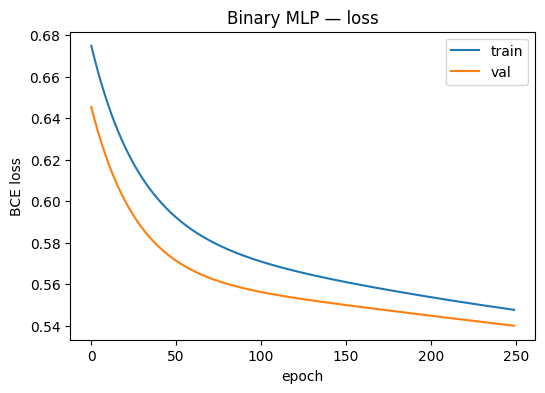

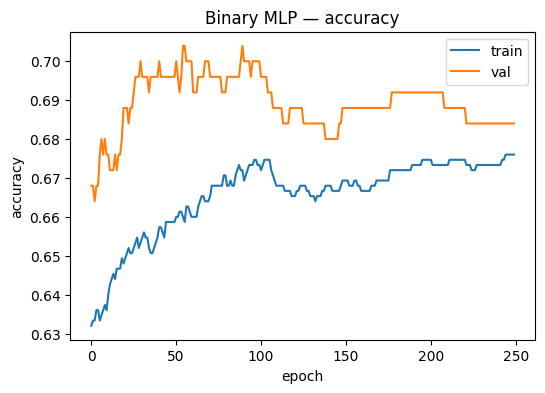

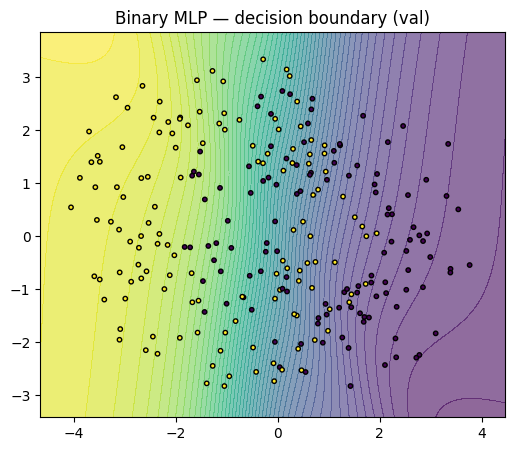

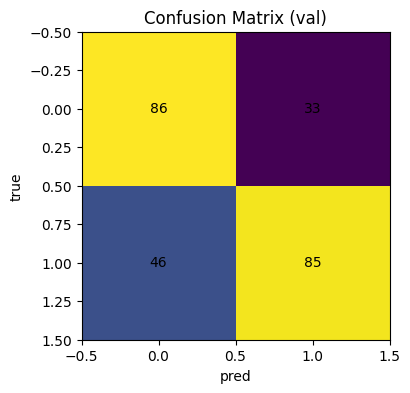

In [ ]:
set_seed(7)

# Synthetic data
n_per_class = 500
r = np.random.rand(n_per_class) * 2.0 + 1.0
theta = np.random.rand(n_per_class) * 2*np.pi
x0 = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1) + np.array([1.0, 0.0])
x1 = np.stack([(r+0.2)*np.cos(theta+0.7), (r+0.2)*np.sin(theta+0.7)], axis=1) + np.array([-1.0, 0.3])

X = np.vstack([x0, x1])
y = np.array([0]*n_per_class + [1]*n_per_class)

(Xtr, ytr), (Xval, yval) = train_val_split(X, y, val_ratio=0.25, seed=7)

H = 8
def init_params(H):
    W1 = np.random.randn(2, H) * 0.5
    b1 = np.zeros((1, H))
    W2 = np.random.randn(H, 1) * 0.5
    b2 = np.zeros((1, 1))
    return W1, b1, W2, b2

def forward(X, W1,b1,W2,b2):
    z1 = X @ W1 + b1
    a1 = np.tanh(z1)
    z2 = a1 @ W2 + b2
    yhat = 1/(1+np.exp(-z2))
    cache = (X, z1, a1, z2, yhat)
    return yhat, cache

def bce_loss(yhat, ytrue):
    ytrue = ytrue.reshape(-1,1)
    eps = 1e-8
    return -np.mean(ytrue*np.log(yhat+eps) + (1-ytrue)*np.log(1-yhat+eps))

def backward(cache, W2, ytrue):
    X, z1, a1, z2, yhat = cache
    ytrue = ytrue.reshape(-1,1)
    dL_dz2 = (yhat - ytrue) / yhat.shape[0]
    dL_dW2 = a1.T @ dL_dz2
    dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
    dL_da1 = dL_dz2 @ W2.T
    dL_dz1 = dL_da1 * (1 - np.tanh(z1)**2)
    dL_dW1 = X.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
    return dL_dW1, dL_db1, dL_dW2, dL_db2

def accuracy(yhat, ytrue):
    preds = (yhat.ravel() >= 0.5).astype(int)
    return (preds == ytrue).mean(), preds

set_seed(0)
W1,b1,W2,b2 = init_params(H)
lr=0.03; epochs=250; reg=1e-4

hist = {"tr_loss":[], "val_loss":[], "tr_acc":[], "val_acc":[]}
for ep in range(epochs):
    yhat, cache = forward(Xtr, W1,b1,W2,b2)
    dW1, db1, dW2, db2 = backward(cache, W2, ytr)
    dW1 += reg*W1; dW2 += reg*W2
    W1 -= lr*dW1; b1 -= lr*db1; W2 -= lr*dW2; b2 -= lr*db2
    tr_loss = bce_loss(forward(Xtr, W1,b1,W2,b2)[0], ytr)
    val_yhat = forward(Xval, W1,b1,W2,b2)[0]
    val_loss = bce_loss(val_yhat, yval)
    tr_acc,_ = accuracy(forward(Xtr, W1,b1,W2,b2)[0], ytr)
    val_acc,_ = accuracy(val_yhat, yval)
    for k,v in [("tr_loss",tr_loss),("val_loss",val_loss),("tr_acc",tr_acc),("val_acc",val_acc)]: hist[k].append(v)

# Curves
plt.figure(figsize=(6,4))
plt.plot(hist["tr_loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.xlabel("epoch"); plt.ylabel("BCE loss"); plt.title("Binary MLP — loss")
plt.legend()
savefig_named("ex2_loss.png"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["tr_acc"], label="train")
plt.plot(hist["val_acc"], label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Binary MLP — accuracy")
plt.legend()
savefig_named("ex2_acc.png"); plt.show()

# Decision boundary
xx, yy = meshgrid2d(X)
grid = np.c_[xx.ravel(), yy.ravel()]
proba = forward(grid, W1,b1,W2,b2)[0].reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, proba, levels=50, alpha=.6)
plt.scatter(Xval[:,0], Xval[:,1], c=yval, s=10, edgecolors='k')
plt.title("Binary MLP — decision boundary (val)")
savefig_named("ex2_decision.png"); plt.show()

# Confusion matrix (val)
val_preds = (forward(Xval, W1,b1,W2,b2)[0].ravel() >= 0.5).astype(int)
cm = confusion_matrix(yval, val_preds, num_classes=2)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.title("Confusion Matrix (val)"); plt.xlabel("pred"); plt.ylabel("true")
savefig_named("ex2_cm.png"); plt.show()



## Exercise 3 — Multi-Class Classification with Synthetic Data and Reusable MLP
**Objective:** Build a **reusable MLP** for multiclass classification with softmax.  
**Deliverables:** learning curves, decision boundary, and confusion matrix.


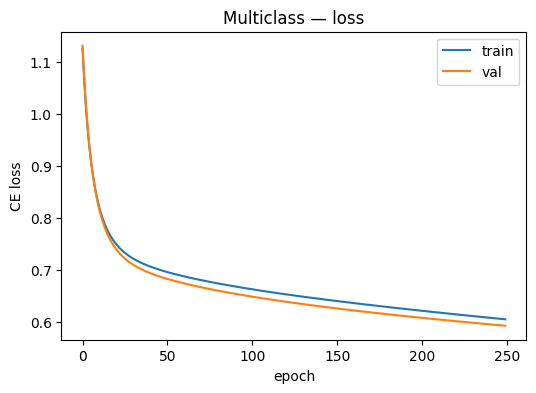

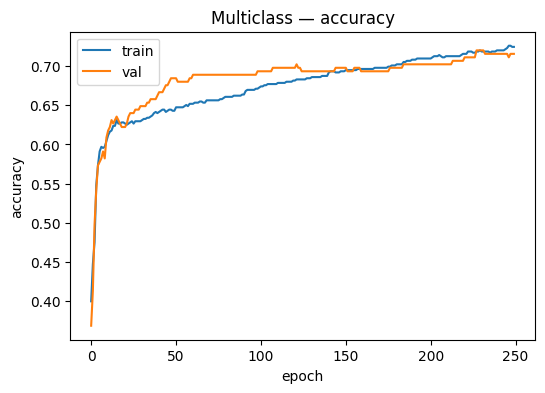

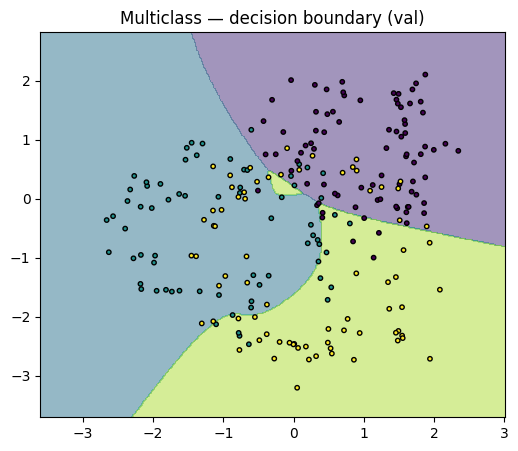

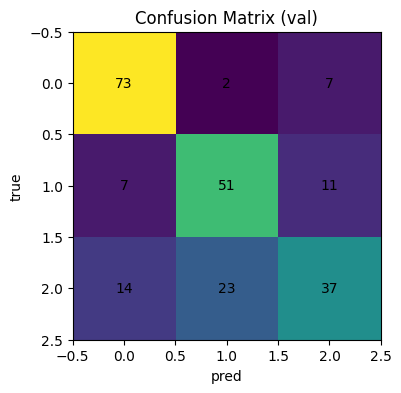

In [ ]:
set_seed(2)

def make_3class(n=900, seed=2):
    set_seed(seed)
    n3 = n//3
    def cloud(r_base, offset):
        r = r_base + 0.3*np.random.randn(n3)
        ang = 2*np.pi*np.random.rand(n3)
        x = np.c_[r*np.cos(ang), r*np.sin(ang)] + offset
        return x
    X0 = cloud(1.0, np.array([ 1.0,  0.8]))
    X1 = cloud(1.3, np.array([-1.0, -0.6]))
    X2 = cloud(1.6, np.array([ 0.3, -1.0]))
    X = np.vstack([X0,X1,X2])
    y = np.array([0]*n3 + [1]*n3 + [2]*n3)
    return X,y

X, y = make_3class(n=900, seed=3)
(Xtr, ytr), (Xval, yval) = train_val_split(X, y, val_ratio=0.25, seed=3)

class MLP:
    def __init__(self, layer_sizes, activation="tanh", seed=0):
        set_seed(seed)
        self.L = len(layer_sizes)-1
        self.W = []
        self.b = []
        for i in range(self.L):
            fan_in, fan_out = layer_sizes[i], layer_sizes[i+1]
            self.W.append(np.random.randn(fan_in, fan_out)*np.sqrt(2.0/fan_in))
            self.b.append(np.zeros((1, fan_out)))
        self.activation = activation
    
    def _act(self, z):
        if self.activation == "relu":
            return np.maximum(0,z), (z>0).astype(float)
        return np.tanh(z), 1 - np.tanh(z)**2
    
    def forward(self, X):
        a = X
        caches = []
        for i in range(self.L-1):
            z = a @ self.W[i] + self.b[i]
            a, da = self._act(z)
            caches.append((a, z, da))
        zL = a @ self.W[-1] + self.b[-1]
        e = np.exp(zL - zL.max(axis=1, keepdims=True))
        yhat = e / e.sum(axis=1, keepdims=True)
        caches.append((a, zL, None))
        return yhat, caches
    
    def loss(self, yhat, ytrue):
        Y = one_hot(ytrue, yhat.shape[1])
        eps=1e-8
        return -np.mean(np.sum(Y*np.log(yhat+eps), axis=1))
    
    def backward(self, X, y, yhat, caches):
        Y = one_hot(y, yhat.shape[1])
        dZ = (yhat - Y) / X.shape[0]
        gradsW = [None]*self.L; gradsB=[None]*self.L
        a_prev = caches[-2][0] if self.L>1 else X
        gradsW[-1] = a_prev.T @ dZ
        gradsB[-1] = np.sum(dZ, axis=0, keepdims=True)
        for i in range(self.L-2, -1, -1):
            a_i_minus = X if i==0 else caches[i-1][0]
            dA = dZ @ self.W[i+1].T
            dZ = dA * caches[i][2]
            gradsW[i] = a_i_minus.T @ dZ
            gradsB[i] = np.sum(dZ, axis=0, keepdims=True)
        return gradsW, gradsB
    
    def step(self, gradsW, gradsB, lr, reg=0.0):
        for i in range(self.L):
            self.W[i] -= lr*(gradsW[i] + reg*self.W[i])
            self.b[i] -= lr*(gradsB[i])
    
    def predict(self, X):
        yhat,_ = self.forward(X); return np.argmax(yhat, axis=1)

net = MLP([2,16,16,3], activation="tanh", seed=0)
epochs=250; lr=0.05; reg=1e-4
hist={"tr_loss":[], "val_loss":[], "tr_acc":[], "val_acc":[]}

for ep in range(epochs):
    yhat, caches = net.forward(Xtr)
    gradsW, gradsB = net.backward(Xtr, ytr, yhat, caches)
    net.step(gradsW, gradsB, lr=lr, reg=reg)
    tr_yhat,_ = net.forward(Xtr); val_yhat,_ = net.forward(Xval)
    tr_loss = net.loss(tr_yhat, ytr); val_loss = net.loss(val_yhat, yval)
    tr_acc = (np.argmax(tr_yhat,1)==ytr).mean()
    val_acc = (np.argmax(val_yhat,1)==yval).mean()
    for k,v in [("tr_loss",tr_loss),("val_loss",val_loss),
                ("tr_acc",tr_acc),("val_acc",val_acc)]: hist[k].append(v)

plt.figure(figsize=(6,4))
plt.plot(hist["tr_loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.xlabel("epoch") 
plt.ylabel("CE loss") 
plt.title("Multiclass — loss")
plt.legend()
savefig_named("ex3_loss.png")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["tr_acc"], label="train")
plt.plot(hist["val_acc"], label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Multiclass — accuracy")
plt.legend()
savefig_named("ex3_acc.png"); plt.show()

xx,yy = meshgrid2d(X)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = net.predict(grid).reshape(xx.shape)
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, levels=3, alpha=.5)
plt.scatter(Xval[:,0], Xval[:,1], c=yval, s=10, edgecolors='k')
plt.title("Multiclass — decision boundary (val)")
savefig_named("ex3_decision.png"); plt.show()

preds = net.predict(Xval)
cm = confusion_matrix(yval, preds, num_classes=3)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.title("Confusion Matrix (val)"); plt.xlabel("pred"); plt.ylabel("true")
savefig_named("ex3_cm.png"); plt.show()



## Exercise 4 — Multi-Class with Deeper MLP
**Objective:** Compare a **shallow** and a **deeper** MLP on the same dataset, using **dropout** and **early stopping** (validation loss).  
**Deliverables:** validation-loss curve (showing early stopping) and decision boundaries.


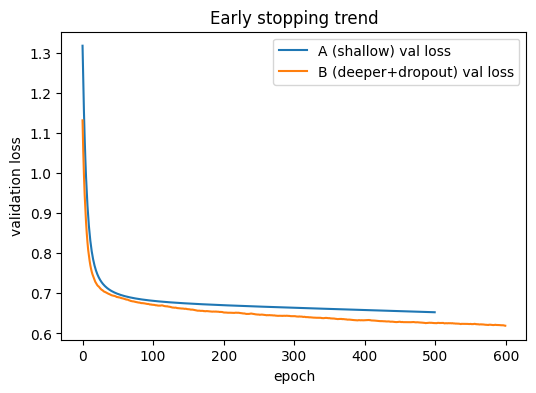

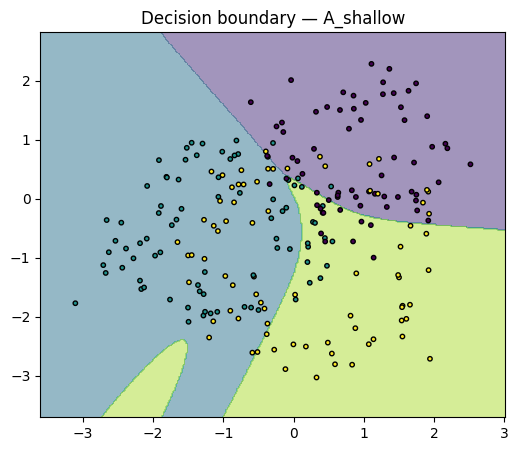

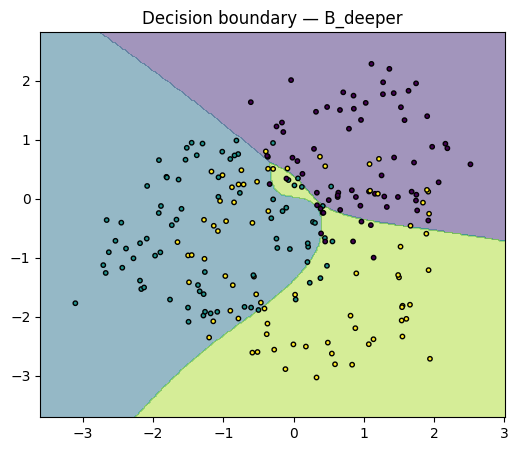

In [ ]:

class DropoutMLP(MLP):
    def __init__(self, layer_sizes, activation="tanh", pdrop=0.2, seed=0):
        super().__init__(layer_sizes, activation, seed)
        self.pdrop = pdrop
    
    def forward(self, X, training=False):
        a = X
        caches = []
        masks = []
        for i in range(self.L-1):
            z = a @ self.W[i] + self.b[i]
            a, da = self._act(z)
            if training and self.pdrop>0:
                mask = (np.random.rand(*a.shape) > self.pdrop).astype(float)
                a = a * mask / (1.0 - self.pdrop)
                masks.append(mask)
            else:
                masks.append(None)
            caches.append((a, z, da))
        zL = a @ self.W[-1] + self.b[-1]
        e = np.exp(zL - zL.max(axis=1, keepdims=True))
        yhat = e / e.sum(axis=1, keepdims=True)
        caches.append((a, zL, None))
        return yhat, caches, masks

    def backward(self, X, y, yhat, caches, masks):
        Y = one_hot(y, yhat.shape[1])
        dZ = (yhat - Y) / X.shape[0]
        gradsW = [None]*self.L 
        gradsB = [None]*self.L
        a_prev = caches[-2][0] if self.L>1 else X
        gradsW[-1] = a_prev.T @ dZ
        gradsB[-1] = np.sum(dZ, axis=0, keepdims=True)
        for i in range(self.L-2, -1, -1):
            a_i_minus = X if i==0 else caches[i-1][0]
            dA = dZ @ self.W[i+1].T
            if masks[i] is not None:
                dA = dA * masks[i] / (1.0 - self.pdrop)
            dZ = dA * caches[i][2]
            gradsW[i] = a_i_minus.T @ dZ
            gradsB[i] = np.sum(dZ, axis=0, keepdims=True)
        return gradsW, gradsB

def train_model(model, Xtr, ytr, Xval, yval, epochs=400, lr=0.05, reg=1e-4, patience=30):
    best = {"epoch":-1, "val_loss":np.inf, "state":None}
    hist={"val_loss":[]}
    for ep in range(epochs):
        yhat, caches, masks = model.forward(Xtr, training=True)
        gradsW, gradsB = model.backward(Xtr, ytr, yhat, caches, masks)
        model.step(gradsW, gradsB, lr=lr, reg=reg)
        val_yhat,_,_ = model.forward(Xval, training=False)
        val_loss = model.loss(val_yhat, yval)
        hist["val_loss"].append(val_loss)
        if val_loss < best["val_loss"] - 1e-4:
            best = {"epoch": ep, "val_loss": val_loss, 
                    "state": ([w.copy() for w in model.W],[b.copy() for b in model.b])}
        elif ep - best["epoch"] > patience:
            model.W, model.b = best["state"]
            break
    return hist, model

# Use Exercise 3 data split
(Xtr, ytr), (Xval, yval) = train_val_split(X, y, val_ratio=0.25, seed=11)

A = DropoutMLP([2,16,3], activation="tanh", pdrop=0.0, seed=1)        # shallow
histA, A = train_model(A, Xtr, ytr, Xval, yval, epochs=500, lr=0.05, reg=1e-4, patience=25)

B = DropoutMLP([2,32,32,3], activation="tanh", pdrop=0.2, seed=1)     # deeper + dropout
histB, B = train_model(B, Xtr, ytr, Xval, yval, epochs=600, lr=0.05, reg=1e-4, patience=35)

# Early-stopping
plt.figure(figsize=(6,4))
plt.plot(histA["val_loss"], label="A (shallow) val loss")
plt.plot(histB["val_loss"], label="B (deeper+dropout) val loss")
plt.xlabel("epoch"); plt.ylabel("validation loss"); plt.title("Early stopping trend")
plt.legend()
savefig_named("ex4_early_val_loss.png"); plt.show()

# Decision boundaries
xx,yy = meshgrid2d(X)
grid = np.c_[xx.ravel(), yy.ravel()]
for tag, model in [("A_shallow",A), ("B_deeper",B)]:
    yhat,_,_ = model.forward(grid, training=False)
    Z = np.argmax(yhat,1).reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, levels=3, alpha=.5)
    plt.scatter(Xval[:,0], Xval[:,1], c=yval, s=10, edgecolors='k')
    plt.title(f"Decision boundary — {tag}")
    savefig_named(f"ex4_decision_{tag}.png"); plt.show()
